<a href="https://colab.research.google.com/github/shreytanwar/CovidPredictionRNN/blob/master/covidrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
  df=pd.read_csv('DataSet.csv')
  df=df['new_cases']
  
  X = df.values
  nan_x=np.isnan(X)
  nan_x = ~nan_x

  x=X[nan_x]

  x=x.reshape(-1,1)

In [ ]:
scale = MinMaxScaler((0,1))
x = scale.fit_transform(x)
print(x.shape[0])

239


In [ ]:
x_new = []
y_new = []
for i in range(60,x.shape[0]):
    x_new.append(x[i-60:i,0])
    y_new.append(x[i,0])

x_new = np.array(x_new)
y_new = np.array(y_new)
print(x_new.shape[0])

179


In [ ]:
SPLIT = 0.1
div = int(x_new.shape[0]*SPLIT)
print(div)

17


In [ ]:
x_train = x_new[:-div]
y_train = y_new[:-div]

x_test = x_new[-div:]
y_test = y_new[-div:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(162, 60) (17, 60) (162,) (17,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
input_dim = 60
hidden_dim = 64

class myLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.LSTM(input_dim,hidden_dim,batch_first=True,num_layers=1)
        self.fc1 = nn.Linear(hidden_dim,1)
    
    def forward(self,x):
        x = x.reshape(-1,1,input_dim)
        # print(x.shape)
        x,(hidden_state,cell_state) = self.l1(x)
        # print(hidden_state.shape)
        x = hidden_state[-1].reshape(-1,hidden_dim)
        x = self.fc1(x)

        return x

In [ ]:
device =  torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = myLSTM()
lass = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
print(model)

model.to(device)

myLSTM(
  (l1): LSTM(60, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


myLSTM(
  (l1): LSTM(60, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
def training(x_train,y_train,x_test,y_test,epochs=180):
    model.train()
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)
    training_loss = []
    val_loss = []
    

    for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()

            with torch.no_grad():
              pred = model(x_test)
              val_l = lass(pred.reshape(-1),y_test)
              val_loss.append(val_l)

            out = model(x_train)
            out = out.reshape(-1)
            loss = lass(out,y_train)
            loss.backward()
            optimizer.step()

            training_loss.append(loss.item())
            if epoch%5==0:
                print(f"epoch {epoch} loss => {loss.item()}")
    
    return training_loss,val_loss

In [ ]:
train,val = training(x_train,y_train,x_test,y_test)

 51%|█████     | 91/180 [00:00<00:00, 447.73it/s]

epoch 0 loss => 0.09054000675678253
epoch 5 loss => 0.08725614845752716
epoch 10 loss => 0.08403442800045013
epoch 15 loss => 0.08087124675512314
epoch 20 loss => 0.07776051014661789
epoch 25 loss => 0.0746966078877449
epoch 30 loss => 0.0716753676533699
epoch 35 loss => 0.0686936229467392
epoch 40 loss => 0.06574895977973938
epoch 45 loss => 0.06283959746360779
epoch 50 loss => 0.059964343905448914
epoch 55 loss => 0.05712267383933067
epoch 60 loss => 0.05431487411260605
epoch 65 loss => 0.0515420101583004
epoch 70 loss => 0.04880601540207863
epoch 75 loss => 0.04610961303114891
epoch 80 loss => 0.04345626011490822
epoch 85 loss => 0.040850091725587845
epoch 90 loss => 0.03829578682780266


100%|██████████| 180/180 [00:00<00:00, 441.59it/s]

epoch 95 loss => 0.03579849749803543
epoch 100 loss => 0.0333636999130249
epoch 105 loss => 0.030997127294540405
epoch 110 loss => 0.028704572468996048
epoch 115 loss => 0.02649182267487049
epoch 120 loss => 0.024364471435546875
epoch 125 loss => 0.02232782356441021
epoch 130 loss => 0.02038675546646118
epoch 135 loss => 0.018545588478446007
epoch 140 loss => 0.016807960346341133
epoch 145 loss => 0.015176757238805294
epoch 150 loss => 0.013654003851115704
epoch 155 loss => 0.012240808457136154
epoch 160 loss => 0.010937308892607689
epoch 165 loss => 0.009742661379277706
epoch 170 loss => 0.008655037730932236
epoch 175 loss => 0.007671653758734465


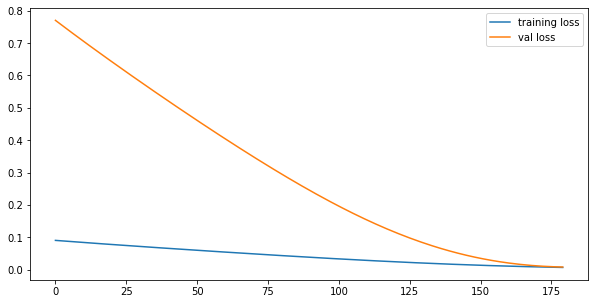

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train,label='training loss')
plt.plot(val,label='val loss')
plt.legend()
plt.show()


In [ ]:
def accuracy(X_test,Y_test):
  x_test = torch.from_numpy(X_test).float().to(device)
  y_test = torch.from_numpy(Y_test).float().to(device)
  model.eval()
  y_pred = model(x_test)
  # print(y_test.shape,y_pred.shape)
  return r2_score(y_test.cpu().detach(),y_pred.reshape(-1).cpu().detach()),y_pred

In [ ]:
acc,y_pred = accuracy(x_train,y_train)
print(acc)

0.8880378135011998


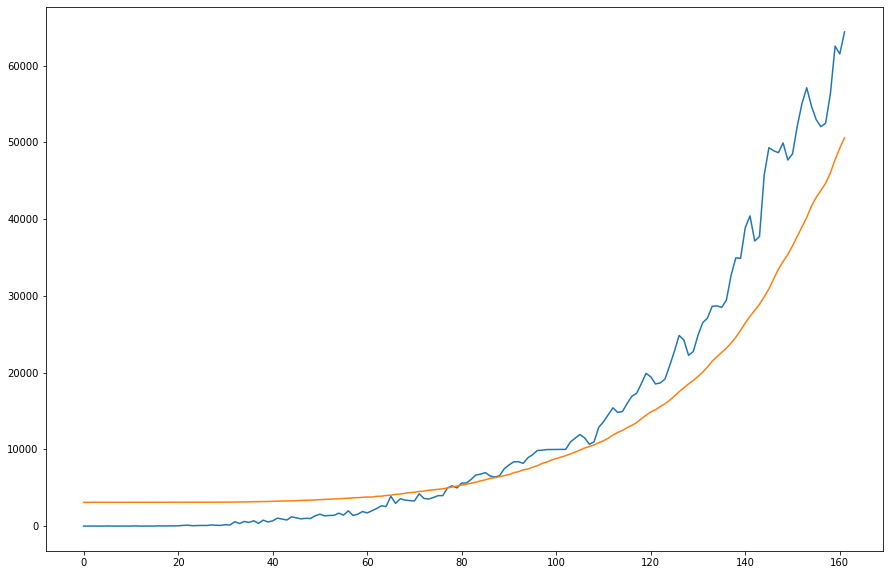

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(scale.inverse_transform(y_train.reshape(-1,1)))
plt.plot(scale.inverse_transform(y_pred.cpu().detach().reshape(-1,1)))

In [ ]:
x_train = torch.from_numpy(x_train).float().to(device)


In [ ]:
x_train.shape

torch.Size([162, 60])

In [ ]:
t=model(x_train[161])
print(scale.inverse_transform(t.cpu().detach().reshape(-1,1)))


[[50593.33642197]]
